# 2 - Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation

In this second notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). This model will achieve improved test perplexity whilst only using a single layer RNN in both the encoder and the decoder.

## Introduction

Let's remind ourselves of the general encoder-decoder model.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

We use our encoder (green) over the embedded source sequence (yellow) to create a context vector (red). We then use that context vector with the decoder (blue) and a linear layer (purple) to generate the target sentence.

In the previous model, we used an multi-layered LSTM as the encoder and decoder.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq4.png?raw=1)

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. By alleviating some of this information compression, we can create a better model!

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). Why? Mainly because that's what they did in the paper (this paper also introduced GRUs) and also because we used LSTMs last time. To understand how GRUs (and LSTMs) differ from standard RNNS, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) link. Is a GRU better than an LSTM? [Research](https://arxiv.org/abs/1412.3555) has shown they're pretty much the same, and both are better than standard RNNs. 

## Preparing Data

All of the data preparation will be (almost) the same as last time, so we'll very briefly detail what each code block does. See the previous notebook for a recap.

We'll import PyTorch, TorchText, spaCy and a few standard modules.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [39]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [40]:
%%bash
python -m spacy download en
# python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Data Download and Preparation

### There are three QASC files:

**Dataset:**

It has following fields
- ID
- Question Stem	
- Choices
- Complete Question	
- Answer Key

**Lets understand dataset more and see how we can define dataset for our model which needs questions and answer.**
- Our model should look into the Question stem and generate answer. So if our question stem is "The sun is responsible for" then answer will be "plants sprouting, blooming and wilting"


#### Break record

In [41]:
!wget https://github.com/allenai/Break/raw/master/break_dataset/Break-dataset.zip
!unzip Break-dataset.zip

--2020-12-30 06:31:46--  https://github.com/allenai/Break/raw/master/break_dataset/Break-dataset.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/allenai/Break/master/break_dataset/Break-dataset.zip [following]
--2020-12-30 06:31:46--  https://raw.githubusercontent.com/allenai/Break/master/break_dataset/Break-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15971078 (15M) [application/zip]
Saving to: ‘Break-dataset.zip.1’

Break-dataset.zip.1 100%[===================>]  15.23M  75.7MB/s    in 0.2s    

2020-12-30 06:31:46 (75.7 MB/s) - ‘Break-dataset.zip.1’ saved [15971078/15971078]

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import string
import json # to read json

In [43]:
!wget http://data.allenai.org/downloads/qasc/qasc_dataset.tar.gz
!tar xvfz qasc_dataset.tar.gz
!rm qasc_dataset.tar.gz

--2020-12-30 06:35:02--  http://data.allenai.org/downloads/qasc/qasc_dataset.tar.gz
Resolving data.allenai.org (data.allenai.org)... 52.218.170.2
Connecting to data.allenai.org (data.allenai.org)|52.218.170.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1616514 (1.5M) [application/x-gzip]
Saving to: ‘qasc_dataset.tar.gz’

qasc_dataset.tar.gz 100%[===================>]   1.54M  --.-KB/s    in 0.09s   

2020-12-30 06:35:02 (16.8 MB/s) - ‘qasc_dataset.tar.gz’ saved [1616514/1616514]

QASC_Dataset/
QASC_Dataset/train.jsonl
QASC_Dataset/test.jsonl
QASC_Dataset/dev.jsonl


## Representing the Meaning of Questions

Question Decomposition Meaning Representation (QDMR), inspired by DB query languages and by semantic parsing. In QDMR, complex questions are expressed through sub-questions (operators) that can be executed in sequence to answer the original question. Each QDMR operator either selects a set of entities, retrieves information about their attributes, or aggregates information over entities.

By abstracting away a question’s context, QDMR allows in principle to query multiple sources for the same question.

A system could potentially answer “Name the political parties of the most densely populated country”, by first returning “the most densely populated country” using a DB query, then “the political parties of #1” using a QA model for te

Now, lets understand QDMR with some examples..
GeoQuery
(a) Which state has the least population density

return states
return population densities of #1
return #1 where #2 is the lowest
ComQA
(a) Who was the first president to serve 3 terms?

return presidents
return terms of #1
return number of #2 for each #1
return #1 where #3 is equal to 3
return first of #4

In [44]:
## Lets understand the data a bit first
trn_break = pd.read_csv("/content/Break-dataset/QDMR/train.csv")
trn_break.head()

,question_id,question_text,decomposition,operators,split
0,ACADEMIC_train_0,return me the homepage of PVLDB .,return homepages ;return #1 of PVLDB,"['select', 'filter']",train
1,ACADEMIC_train_1,"return me the homepage of "" H. V. Jagadish "" .",return homepages ;return #1 of H. V. Jagadish,"['select', 'filter']",train
2,ACADEMIC_train_10,"return me the number of references of "" Making...",return references ;return #1 of Making databa...,"['select', 'filter', 'aggregate']",train
3,ACADEMIC_train_100,return me the number of papers in VLDB confere...,return papers ;return #1 in VLDB conference ;r...,"['select', 'filter', 'filter', 'aggregate']",train
4,ACADEMIC_train_101,return me the number of authors who have paper...,return papers ;return #1 containing keyword Re...,"['select', 'filter', 'project', 'aggregate']",train


In [45]:
## Lets understand the data a bit first
dev_break = pd.read_csv("/content/Break-dataset/QDMR/dev.csv")
dev_break.head()

,question_id,question_text,decomposition,operators,split
0,ATIS_dev_0,what flights are available tomorrow from denve...,return flights ;return #1 from denver ;return...,"['select', 'filter', 'filter', 'filter']",dev
1,ATIS_dev_1,show me the afternoon flights from washington ...,return flights ;return #1 from washington ;re...,"['select', 'filter', 'filter', 'filter']",dev
2,ATIS_dev_10,show me the flights from atlanta to baltimore,return flights ;return #1 from atlanta ;retur...,"['select', 'filter', 'filter']",dev
3,ATIS_dev_100,i want a flight from houston to memphis on tue...,return flights ;return #1 from houston ;retur...,"['select', 'filter', 'filter', 'filter', 'filt...",dev
4,ATIS_dev_101,what are the cheapest one way flights from atl...,return flights ;return #1 from atlanta ;retur...,"['select', 'filter', 'filter', 'filter', 'proj...",dev


In [46]:
## Lets understand the data a bit first
test_break = pd.read_csv("/content/Break-dataset/QDMR/test.csv")
test_break.head(1)

,question_id,question_text,decomposition,operators,split
0,ATIS_test_0,what flights go from dallas to phoenix,NaN,NaN,test


In [47]:
test_break.shape

(8069, 5)

In [48]:
dev_break.shape # No of rows 2811774 and 7 column

(7760, 5)

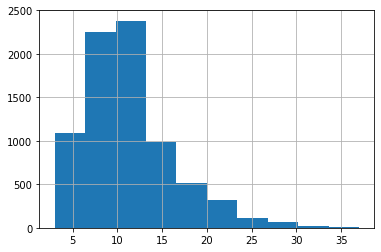

In [49]:
#Distribution of word count for the dev_break
# Let us take a look at distribution of words in each question_text
dev_break.question_text.str.split().\
    map(lambda x: len(x)).\
    hist()

# We can see here that most of the question_text contain 5 to 15 words while there are a few tweets having a word count aobve 20.

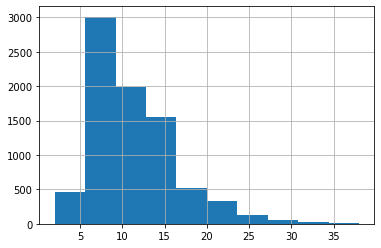

In [50]:
#Distribution of word count for the test_break
# Let us take a look at distribution of words in each question_text
test_break.question_text.str.split().\
    map(lambda x: len(x)).\
    hist()

### Data Preparation

In [51]:
import random
import torch, torchtext
from torchtext import data 

In [52]:
## Lets keep only required columns into the dataframe
trn_break.drop(['question_id', 'operators','split'], axis=1, inplace=True)
dev_break.drop(['question_id', 'operators','split'], axis=1, inplace=True)

In [53]:
test_break.drop(['question_id', 'operators','split'], axis=1, inplace=True)

In [54]:
trn_break.head(1)

,question_text,decomposition
0,return me the homepage of PVLDB .,return homepages ;return #1 of PVLDB


### Utility Functions

**Random Deletion**

In [55]:
# randomly delete words from a sentence with a given probability

def random_deletion(sentence, p=0.5): 
    # return if single word
    if len(sentence) == 1: 
        return sentence
    # delete words
    remaining = list(filter(lambda x: random.uniform(0,1) > p, sentence)) 
    # if nothing left, sample a random word
    if len(remaining) == 0: 
        return [random.choice(sentence)] 
    else:
        return remaining

**Random Swap**

In [56]:
# randomly swap a pair of words in a sentence for a given # of times

def random_swap(sentence, n=5): 
    if len(sentence) < 2:
      return sentence
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

**Back Translation**

In [57]:
# translate a sentence to a random language,
# and translate back to original language

def back_translate(sentence, p=0.1):
  # do nothing with probability of 1-p
  if random.uniform(0,1) > p:
    return sentence

  # combine tokenized sentence into one string
  sentence = ' '.join(sentence)

  # instantiate translator
  translator = google_translator()

  # choose a target language
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  #print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")

  # translate to the target language
  translations = translator.translate(sentence, lang_tgt=trans_lang) 
  #print(translations)

  # translate back to original language
  translations_en_random = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 
  #print(translations_en_random)

  # select only one translation
  if len(translations_en_random) > 1:
    translations_en_random = translations_en_random[0]

  return word_tokenize(translations_en_random)

**Carry Out Data Augmentation**

In [58]:
# for example in train.examples: 
#   example.tweets = back_translate(example.tweets, p=0.01)
#   example.tweets = random_deletion(example.tweets, p=0.1)
#   example.tweets = random_swap(example.tweets, n=1)

### Tabular File Reading

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
# from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import random
import math
import time
import torch
from torchtext import data
from torchtext import datasets
import pandas as pd

In [60]:
# Creating my home directory for keeping all the CSV files
directory = 'data'
if not os.path.exists(directory):
    os.makedirs('data')
    print("Directory '% s' created" % directory)

In [61]:
# saving all the dataframe into CSV file.
trn_break.to_csv("/content/data/train.csv", index=False)
dev_break.to_csv("/content/data/dev.csv", index=False)

In [62]:
test_break.to_csv("/content/data/test.csv", index=False)

In [63]:
## Now lets check how many null we have in training data
tweet_train = pd.read_csv("/content/data/train.csv")
null_columns_tweet_train = tweet_train.columns[tweet_train.isnull().any()]
tweet_train[null_columns_tweet_train].isnull().sum()

Series([], dtype: float64)

In [64]:
## Check for null in valid data
tweet_valid = pd.read_csv("/content/data/dev.csv")
null_columns_tweet_valid = tweet_valid.columns[tweet_valid.isnull().any()]
tweet_valid[null_columns_tweet_valid].isnull().sum()

Series([], dtype: float64)

In [65]:
from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import datasets

In [66]:
# !shuf -n 63543 /content/data/Tweet_valid_nl.csv > /content/data/Tweet_Train_reduced.csv
# !{ echo 'text_x, text_y'; cat /content/data/Tweet_Train_reduced.csv; } > /content/data/Tweet_Train_reduced_fn.csv

In [67]:
# create Field objects
QUESTION = data.Field(
    # sequential = True,
    tokenize = 'spacy', 
    # batch_first =True,
    #  use_vocab=True,
    lower = True,
    init_token = '<sos>', 
    eos_token = '<eos>', 
    #  include_lengths=True
    )

RESPONSE = data.Field(tokenize ='spacy',
                      # sequential = True, 
                      # include_lengths=True,
                      lower = True,
                      # is_target=True,
                      init_token = '<sos>', 
                      eos_token = '<eos>', 
                      # batch_first =True
                      )

fields = [('question_text', QUESTION), ('decomposition', RESPONSE)]

In [68]:
# load the dataset in json format
train_ds, valid_ds = data.TabularDataset.splits(
   path = 'data',
   train = 'train.csv',
   validation = 'dev.csv',
   format = 'csv',
   fields = fields,
   skip_header = True
)

# check an example
print(vars(train_ds[0]))

{'question_text': ['return', 'me', 'the', 'homepage', 'of', 'pvldb', '.'], 'decomposition': ['return', 'homepages', ';', 'return', '#', '1', 'of', ' ', 'pvldb']}


In [69]:
train_ds[0].__dict__.keys()

dict_keys(['question_text', 'decomposition'])

In [70]:
## we get an Example object. The Example object bundles the attributes of a single data point together. 
# We also see that the text has already been tokenized for us, but has not yet been converted to integers
vars(train_ds.examples[10])

{'decomposition': ['return',
  'university',
  'of',
  'michigan',
  ';',
  'return',
  'papers',
  'in',
  '#',
  '1',
  ';',
  'return',
  'number',
  'of',
  '#',
  '2'],
 'question_text': ['return',
  'me',
  'the',
  'number',
  'of',
  'papers',
  'in',
  '"',
  'university',
  'of',
  'michigan',
  '"',
  '.']}

In [71]:
try:
    print(len(train_ds[10]))
except:
    print(train_ds[10].question_text)

['return', 'me', 'the', 'number', 'of', 'papers', 'in', '"', 'university', 'of', 'michigan', '"', '.']


In [72]:
# Before creating iterators of the Datasets we need to build the vocabulary for each Field object:
# This makes torchtext go through all the elements in the training set, check the contents corresponding to the TEXT field, 
# and register the words in its vocabulary. Torchtext has its own class called Vocab for handling the vocabulary. 
# The Vocab class holds a mapping from word to id in its stoi attribute and a reverse mapping in its itos attribute
QUESTION.build_vocab(train_ds,
                  # max_size=20000,
                  min_freq=2)
RESPONSE.build_vocab(train_ds,
                    #  max_size=20000,
                     min_freq=2
                     )

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
print(f"Unique tokens in source (BREAK) vocabulary: {len(QUESTION.vocab)}")
print(f"Unique tokens in target (RESPONSE) vocabulary: {len(RESPONSE.vocab)}")

Unique tokens in source (BREAK) vocabulary: 9494
Unique tokens in target (RESPONSE) vocabulary: 9499


In [75]:
BATCH_SIZE = 64
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds),
    # sort_key=lambda x: len(x.text_x), # the BucketIterator needs to be told what function it should use to group the data.
    # sort_within_batch=True,
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.question_text),
    sort = True,
    # repeat=False, # we pass repeat=False because we want to wrap this Iterator layer
    device = device)
# https://torchtext.readthedocs.io/en/latest/examples.html

In [76]:
b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'question_text', 'decomposition'])

In [77]:
train_ds.fields

{'decomposition': <torchtext.data.field.Field at 0x7fe766bc6748>,
 'question_text': <torchtext.data.field.Field at 0x7fe7671fb2b0>}

In [78]:
type(train_iterator)
type(train_ds)

torchtext.data.dataset.TabularDataset

## Building the Seq2Seq Model

### Encoder

The encoder is similar to the previous one, with the multi-layer LSTM swapped for a single-layer GRU. We also don't pass the dropout as an argument to the GRU as that dropout is used between each layer of a multi-layered RNN. As we only have a single layer, PyTorch will display a warning if we try and use pass a dropout value to it.

Another thing to note about the GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

$$\begin{align*}
h_t &= \text{GRU}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})\\
h_t &= \text{RNN}(e(x_t), h_{t-1})
\end{align*}$$

From the equations above, it looks like the RNN and the GRU are identical. Inside the GRU, however, is a number of *gating mechanisms* that control the information flow in to and out of the hidden state (similar to an LSTM). Again, for more info, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) excellent post. 

The rest of the encoder should be very familar from the last session, it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

This is identical to the encoder of the general seq2seq model, with all the "magic" happening inside the GRU (green).

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq5.png?raw=1)

In [79]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) #no dropout as only one layer!
        
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

## Decoder

The decoder is where the implementation differs significantly from the previous model and we alleviate some of the information compression.

Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$

Note how this context vector, $z$, does not have a $t$ subscript, meaning we re-use the same context vector returned by the encoder for every time-step in the decoder. 

Before, we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f$, only using the top-layer decoder hidden state at that time-step, $s_t$, as $\hat{y}_{t+1}=f(s_t^L)$. Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

Thus, our decoder now looks something like this:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq6.png?raw=1)

Note, the initial hidden state, $s_0$, is still the context vector, $z$, so when generating the first token we are actually inputting two identical context vectors into the GRU.

How do these two changes reduce the information compression? Well, hypothetically the decoder hidden states, $s_t$, no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of $y_t$ to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state. 

However, this hypothesis is just a hypothesis, it is impossible to determine how the model actually uses the information provided to it (don't listen to anyone that says differently). Nevertheless, it is a solid intuition and the results seem to indicate that this modifications are a good idea!

Within the implementation, we will pass $d(y_t)$ and $z$ to the GRU by concatenating them together, so the input dimensions to the GRU are now `emb_dim + hid_dim` (as context vector will be of size `hid_dim`). The linear layer will take $d(y_t), s_t$ and $z$ also by concatenating them together, hence the input dimensions are now `emb_dim + hid_dim*2`. We also don't pass a value of dropout to the GRU as it only uses a single layer.

`forward` now takes a `context` argument. Inside of `forward`, we concatenate $y_t$ and $z$ as `emb_con` before feeding to the GRU, and we concatenate $d(y_t)$, $s_t$ and $z$ together as `output` before feeding it through the linear layer to receive our predictions, $\hat{y}_{t+1}$.

In [80]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

## Seq2Seq Model

Putting the encoder and decoder together, we get:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [81]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is the context
        context = self.encoder(src)
        
        #context also used as the initial hidden state of the decoder
        hidden = context
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

# Training the Seq2Seq Model

The rest of this session is very similar to the previous one. 

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [82]:
INPUT_DIM = len(QUESTION.vocab)
OUTPUT_DIM = len(RESPONSE.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [83]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9494, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9499, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=9499, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We print out the number of parameters.

Even though we only have a single layer RNN for our encoder and decoder we actually have **more** parameters  than the last model. This is due to the increased size of the inputs to the GRU and the linear layer. However, it is not a significant amount of parameters and causes a minimal amount of increase in training time (~3 seconds per epoch extra).

In [84]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,182,299 trainable parameters


We initiaize our optimizer.

In [85]:
optimizer = optim.Adam(model.parameters())

We also initialize the loss function, making sure to ignore the loss on `<pad>` tokens.

In [86]:
# TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
TRG_PAD_IDX = RESPONSE.vocab.stoi[QUESTION.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [87]:
def train(model, iterator, optimizer, criterion, clip, epoch):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        # src = batch.src
        src = batch.question_text
        # trg = batch.trg
        trg = batch.decomposition
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        if(not i % 50):
          print(f"Epoch:{epoch}, Batch:{i}, Batch Loss:{loss.item()}")        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [88]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # src = batch.src
            src = batch.question_text
            # trg = batch.trg
            trg = batch.decomposition

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We'll also define the function that calculates how long an epoch takes.

In [89]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [90]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, epoch)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch:0, Batch:0, Batch Loss:9.165456771850586
Epoch:0, Batch:50, Batch Loss:3.1182973384857178
Epoch:0, Batch:100, Batch Loss:2.9083306789398193
Epoch:0, Batch:150, Batch Loss:2.6808114051818848
Epoch:0, Batch:200, Batch Loss:3.2491908073425293
Epoch:0, Batch:250, Batch Loss:2.484760284423828
Epoch:0, Batch:300, Batch Loss:2.5409717559814453
Epoch:0, Batch:350, Batch Loss:3.5789520740509033
Epoch:0, Batch:400, Batch Loss:3.807363986968994
Epoch:0, Batch:450, Batch Loss:3.7942562103271484
Epoch:0, Batch:500, Batch Loss:3.004511594772339
Epoch:0, Batch:550, Batch Loss:2.5612082481384277
Epoch:0, Batch:600, Batch Loss:2.9569756984710693
Epoch:0, Batch:650, Batch Loss:2.5806310176849365
Epoch: 01 | Time: 5m 0s
	Train Loss: 3.169 | Train PPL:  23.773
	 Val. Loss: 4.823 |  Val. PPL: 124.333
Epoch:1, Batch:0, Batch Loss:3.4683804512023926
Epoch:1, Batch:50, Batch Loss:1.9753448963165283
Epoch:1, Batch:100, Batch Loss:1.844138264656067
Epoch:1, Batch:150, Batch Loss:1.7947677373886108
Epoch:1

Finally, we test the model on the test set using these "best" parameters.

In [93]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.073 | Test PPL:  58.708 |


In [ ]:
## we need to predict answer